In [84]:
import re

import scipy.stats as stats
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter


In [85]:

def cast_to_numeric(x):
    try:
        return int(x)
    except ValueError:
        return float(x)

with open('SDM_4.dat') as f:
    header = [cast_to_numeric(x) for x in f.readline().split()]
    data = f.read()
index_regex = r"([\d] [\d])"
split_data = re.split(index_regex, data)
frequencies = np.array(split_data[0].split()).astype(float)
S_entries = split_data[1:]
r, B, K, n_f = header

q = r-1
N = (n_f-1)*2

In [86]:
r, B, K, n_f, N

(4, 0.0954345, 194, 1025, 2048)

In [87]:
n_f == frequencies.shape[0]

True

In [88]:
matrices = [np.zeros([r,r], dtype=complex) for freq in frequencies]
for l, matric_index in enumerate(S_entries[::2]):
    row, col = [int(x) for x in matric_index.split()]
    reals, ims = S_entries[l*2+1].split('\n\n')
    reals = np.array(reals.split(), dtype=complex)
    ims = np.array(ims.split(), dtype=complex)
    entries = reals+ims*1j
    for freq_index, entry in enumerate(entries):
        if row == col:
            assert entry == np.conj(entry)
        matrices[freq_index][row-1, col-1] = entry
        matrices[freq_index][col-1, row-1] = np.conj(entry)

In [72]:
def matrix_partial_coherence(inv_S):
    diag_S = np.diag(inv_S)
    assert np.all(np.imag(diag_S) < 1e-8)
    diag_S = np.real(diag_S)
    denom = (diag_S[...,np.newaxis]*diag_S[np.newaxis,...])
    return np.abs(inv_S)**2/denom

In [73]:
# Good to know what are units of freq

# Construct index for valid frequencies
def generate_freq_grid(frequencies, B):
    # Should start from B/2 go to 1/2-B/2
    selector = (frequencies > B/2) & (frequencies < 0.5-B/2)
    # Find the gap between frequencies
    freq_delta = frequencies[1] - frequencies[0]
    # Find therefore how many indices we want to step until we return to true
    index_gap = np.ceil(B/freq_delta)
    # Do that from the first valid index
    for counter, freq_index in enumerate(np.where(selector)[0]):
        if not counter % index_gap == 0:
            selector[freq_index] = False
    return selector, frequencies[selector]

test_grid = 100
generate_freq_grid(np.arange(test_grid+1)/(2*test_grid), 0.03)

(array([False, False, False, False,  True, False, False, False, False,
        False,  True, False, False, False, False, False,  True, False,
        False, False, False, False,  True, False, False, False, False,
        False,  True, False, False, False, False, False,  True, False,
        False, False, False, False,  True, False, False, False, False,
        False,  True, False, False, False, False, False,  True, False,
        False, False, False, False,  True, False, False, False, False,
        False,  True, False, False, False, False, False,  True, False,
        False, False, False, False,  True, False, False, False, False,
        False,  True, False, False, False, False, False,  True, False,
        False, False, False, False,  True, False, False, False, False,
        False, False]),
 array([0.02, 0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29, 0.32,
        0.35, 0.38, 0.41, 0.44, 0.47]))

In [74]:
freq_matrices = np.stack(matrices, axis=-1)
selector, filtered_frequencies = generate_freq_grid(frequencies, B)
filtered_matrices = freq_matrices[:,:,selector]
filtered_matrices = np.moveaxis(filtered_matrices, -1, 0) # Move frequency axis to front so we can loop apply
A = selector.sum()

In [75]:
partial_coherences = [matrix_partial_coherence(x) for x in filtered_matrices]
log_inverse_partial_coherences = [np.log(1-x) for x in partial_coherences]
W = -2*K*np.sum(log_inverse_partial_coherences, axis=0)
W

/tmp/ipykernel_9218/2887475260.py:2: RuntimeWarning: divide by zero encountered in log
  log_inverse_partial_coherences = [np.log(1-x) for x in partial_coherences]


array([[         inf,   7.00215567, 368.40925803,  61.68064729],
       [  7.00215567,          inf,  13.63465739,   6.05699952],
       [368.40925803,  13.63465739,          inf, 194.54715827],
       [ 61.68064729,   6.05699952, 194.54715827,          inf]])

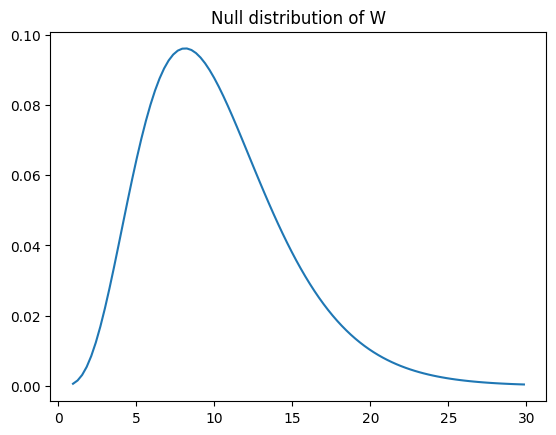

In [76]:
null_distribution = stats.gamma(A, scale=2*K/(K-q))
null_sample = null_distribution.rvs(1000)
dist_domain = np.linspace(min(null_sample),max(null_sample), 100)
plt.plot(dist_domain, null_distribution.pdf(dist_domain))
plt.title("Null distribution of W")
plt.savefig("null_dist.png", dpi=300)

In [77]:
alpha = 0.05
critical_regions = []
for i in range(6):
    # Add 1 to critical region because of zero indexing
    critical_regions.append(null_distribution.ppf(1-(alpha/(i+1))))

W_vals = []
for i in range(0,r):
    for j in range(i+1,r):
        W_vals.append((W[i,j], (i+1,j+1)))

W_vals.sort(key=lambda x: x[0], reverse=True)
critical_regions.sort(reverse=True)

In [78]:
results = pd.DataFrame({
    'i': range(len(critical_regions),0,-1),
    'Edge': [x[1] for x in W_vals],
    'W': [x[0] for x in W_vals],
    'C': critical_regions
})

results['present'] = results['C'] < results['W']
pretty_results = results.copy()
pretty_results = pretty_results.rename(columns={
    'W': '$W_{(i)}$',
    'C': f'$C_i({alpha})$',
    'present': 'Edge present?'
})
pretty_results = pretty_results.set_index('i')
pretty_results.to_latex('results.txt', escape=False)
pretty_results

/tmp/ipykernel_9218/2991935386.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pretty_results.to_latex('results.txt', escape=False)


,Edge,$W_{(i)}$,$C_i(0.05)$,Edge present?
i,,,,
6,"(1, 3)",368.409258,24.108638,True
5,"(3, 4)",194.547158,23.573794,True
4,"(1, 4)",61.680647,22.912565,True
3,"(2, 3)",13.634657,22.048345,False
2,"(1, 2)",7.002156,20.804903,False
1,"(2, 4)",6.057000,18.594583,False


# Plotting results

In [79]:
freq_response_partial_coherence = np.stack(partial_coherences, axis=-1)

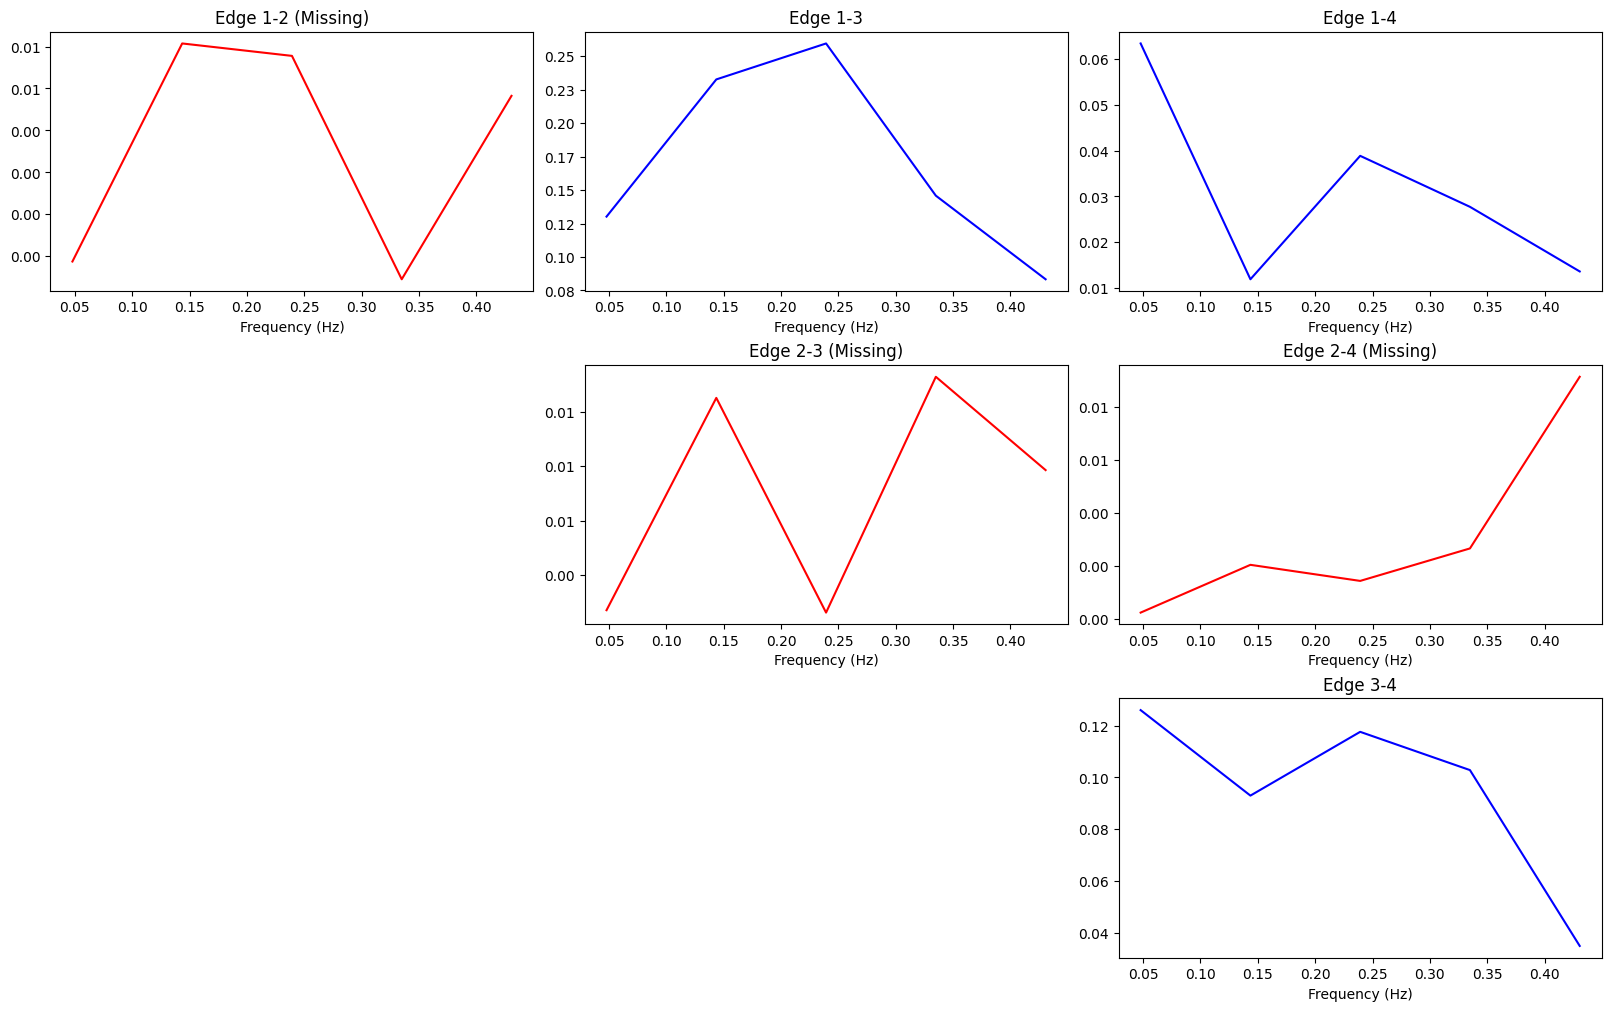

In [80]:
fig, axs = plt.subplots(nrows=r-1, ncols=r-1, figsize=(16,10), layout='constrained')
for i in range(0,r):
    for j in range(i+1,r):
        
        if freq_response_partial_coherence[i,j,:].mean() < 0.01:
            axs[i][j-1].set_title(f"Edge {i+1}-{j+1} (Missing)")
            axs[i][j-1].plot(filtered_frequencies, freq_response_partial_coherence[i,j,:], color="red")
        else:
            axs[i][j-1].set_title(f"Edge {i+1}-{j+1}")
            axs[i][j-1].plot(filtered_frequencies, freq_response_partial_coherence[i,j,:], color="blue")
        axs[i][j-1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[i][j-1].set_xlabel("Frequency (Hz)")
    for j in range(0,i):
        if i < 3:
            axs[i][j].set_visible(False)
fig.savefig('Part_B_results.png', dpi=300)

# Exercise 2a

In [81]:
sample_data = [
 126.21,
 94.68,
 114.89,
 119.82,
 94.28,
 135.78,
 102.20,
 117.04,
 175.44,
 130.10,
 199.46,
 127.09,
 101.00,
 122.33,
 130.84,
 116.71,
 127.55,
 91.46,
 119.40,
 130.80,
 129.39,
 138.74,
 116.89,
 131.02,
 105.13,
 112.83,
 115.18,
 69.15,
 113.82,
 118.85,
 127.34,
 105.90,
 111.52,
 145.24,
 108.54,
 105.54,
 98.48,
 146.25,
 124.25,
 91.43,
]

0.4


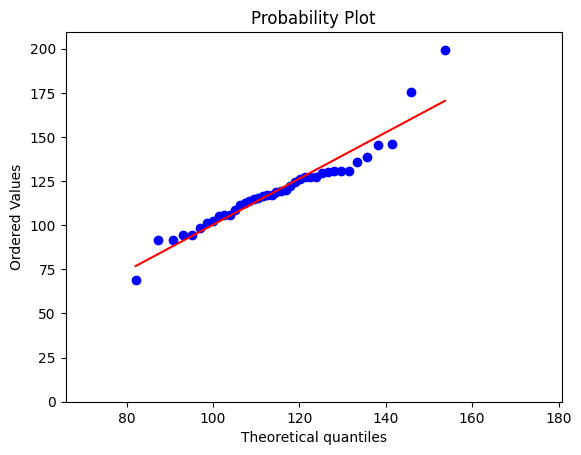

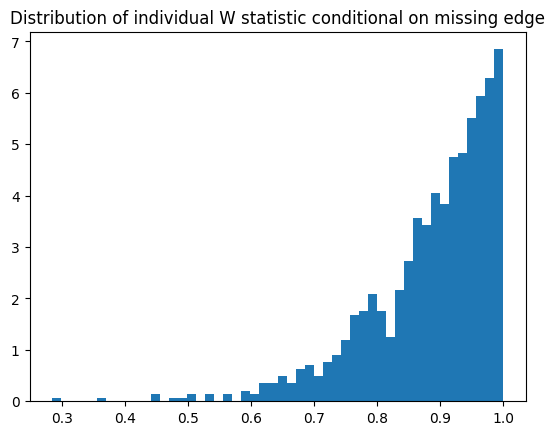

In [82]:
A = 46
K = 10
r = 3
q = r -1
W = stats.gamma(A, scale=2*K/(K-q))
fig, ax = plt.subplots()
stats.probplot(sample_data, dist=W, plot= ax)
fig.savefig("QQ_plot.png", dpi=300)
plt.hist(W.rvs(1000), bins=50, density=True)
print(1/(2*K/(K-q)))
plt.figure()
plt.title("Distribution of individual W statistic conditional on missing edge")
plt.hist(stats.beta(K-q, 1).rvs(1000), bins=50, density=True)
pass